In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from datetime import datetime, timedelta
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
##### load data sets
os.chdir('/home/roman/Documents/Projects/Bubbles')
datasets_original = ['^GSPC.csv', '^N225.csv']
datasets = []
for d in datasets_original:
    data_original = pd.read_csv(d, index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y/%m/%d')
    data_norm = data_original['Close'] / data_original['Close'][-1]
    data_ch = data_original['Close'].pct_change()
    window = 10
    data_vol = data_original['Close'].pct_change().rolling(window).std()
    data = pd.concat([data_original['Close'], data_norm, data_ch, data_vol], axis=1).dropna()
    data.columns = ['price', 'norm', 'ch', 'vol']
    datasets.append(data)

In [3]:
##### find crashes
drawdowns = []
crashes = []
crash_threshold = -0.11
for df in datasets:
    # find drawdowns (consecutive price decreases)
    pmin_pmax = (df['price'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    # make sure drawdowns start with pmax, end with pmin:
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])
    D = (np.array(df['price'][pmin.index]) - np.array(df['price'][pmax.index])) \
    / np.array(df['price'][pmax.index])
    d = {'Date':pmax.index, 'drawdown':D, 'd_start': pmax.index, 'd_end': pmin.index}    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.reindex(df.index).fillna(0)
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    drawdowns.append(df_d)
    df_d = df_d.sort_values(by='Date')
    df_c = df_d[df_d['drawdown'] < crash_threshold]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'rank']
    c_st = list(df_c['crash_st'])
    d_st = [df['price'][(c_s-timedelta(int(252*5/12))):c_s].idxmax() for c_s in c_st]
    d_st_adj = [max(d, c_prev) for d, c_prev in zip(d_st[1:], c_st[:-1])]
    d_st_adj = [d_st[0]] + d_st_adj
    df_c['down_st'] = d_st_adj
    crashes.append(df_c)
df_combined = []  
for i in range(len(datasets)):
    df_combined.append(pd.concat([datasets[i], drawdowns[i]], axis=1))

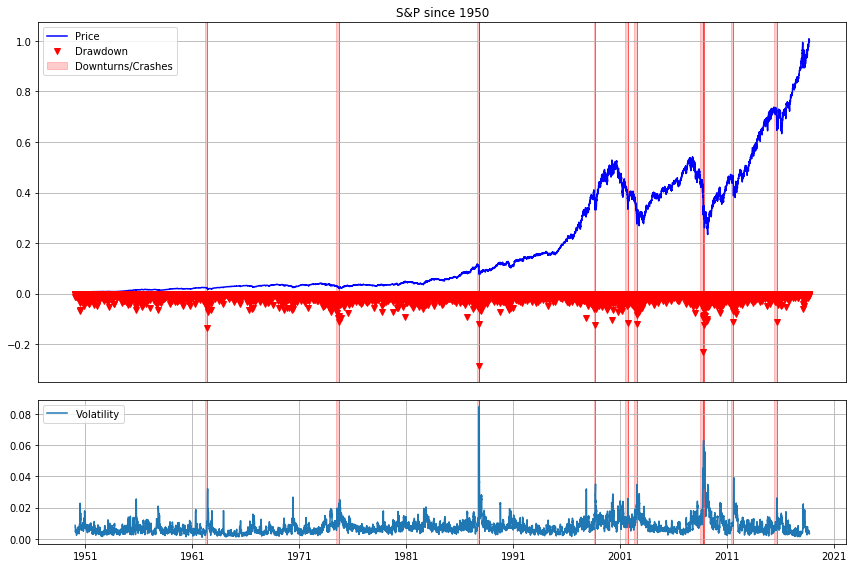

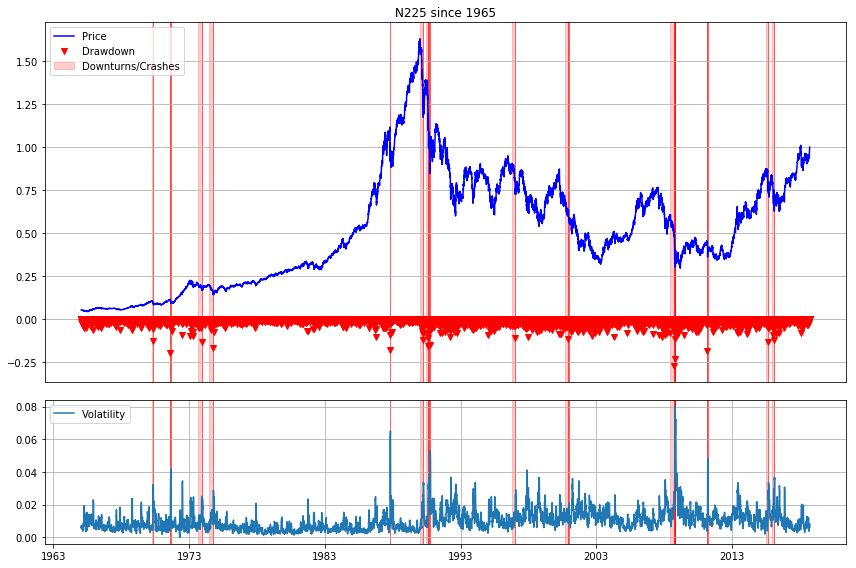

In [4]:
##### plot prices, crashes, volatility since beginning for each df:
rcParams['figure.figsize'] = 12, 8
plt_titles = ['S&P since 1950', 'N225 since 1965']
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['norm'], color='blue')
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(crashes[i]['down_st'], \
         crashes[i]['crash_st'])]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.plot(df_combined[i]['drawdown'], color='red', marker='v',linestyle='')
    plt.title(plt_titles[i])
    plt.grid()
    plt.xticks([])
    plt.legend(['Price', 'Drawdown', 'Downturns/Crashes'])
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(crashes[i]['down_st'], \
         crashes[i]['crash_st'])]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.legend(['Volatility'])
    plt.grid()
    plt.tight_layout()
    plt.show()

In [5]:
##### prepare data for regression model:
predictors = []
outcomes = []
for df, c in zip(df_combined, crashes):
    pred = {}
    out = {}
    for date in df.index[252:-126]: # <--subtract 126 days in the end
        pr_ch_12_6m = df['ch'][(date-timedelta(252)):(date-timedelta(126))].mean()
        pr_ch_6_3m = df['ch'][(date-timedelta(125)):(date-timedelta(63))].mean()
        pr_ch_3_2m = df['ch'][(date-timedelta(62)):(date-timedelta(42))].mean()
        pr_ch_2_1m = df['ch'][(date-timedelta(41)):(date-timedelta(21))].mean()
        pr_ch_4_3w = df['ch'][(date-timedelta(20)):(date-timedelta(15))].mean()
        pr_ch_3_2w = df['ch'][(date-timedelta(15)):(date-timedelta(10))].mean()
        pr_ch_2_1w = df['ch'][(date-timedelta(10)):(date-timedelta(5))].mean()
        pr_ch_1_0w = df['ch'][(date-timedelta(5)):(date-timedelta(0))].mean()
        vol_12_6m = df['vol'][(date-timedelta(252)):(date-timedelta(126))].mean()
        vol_6_3m = df['vol'][(date-timedelta(125)):(date-timedelta(63))].mean()
        vol_3_2m = df['vol'][(date-timedelta(62)):(date-timedelta(42))].mean()
        vol_2_1m = df['vol'][(date-timedelta(41)):(date-timedelta(21))].mean()
        vol_4_3w = df['vol'][(date-timedelta(20)):(date-timedelta(15))].mean()
        vol_3_2w = df['vol'][(date-timedelta(15)):(date-timedelta(10))].mean()
        vol_2_1w = df['vol'][(date-timedelta(10)):(date-timedelta(5))].mean()
        vol_1_0w = df['vol'][(date-timedelta(5)):(date-timedelta(0))].mean()
        pred[date] = [pr_ch_12_6m, pr_ch_6_3m, pr_ch_3_2m, pr_ch_2_1m, pr_ch_4_3w, \
              pr_ch_3_2w, pr_ch_2_1w, pr_ch_1_0w, vol_12_6m, vol_6_3m, vol_3_2m, \
              vol_2_1m, vol_4_3w, vol_3_2w, vol_2_1w, vol_1_0w]
        d_6m = max([date <= d and date+timedelta(6*21) > d for d in c['down_st']])
        c_6m = max([date <= c and date+timedelta(6*21) > c for c in c['crash_st']])
        if max([date > d and date < c for d, c in zip(c['down_st'], c['crash_st'])]):
            d_6m=d_3m=d_1m=False
        out[date] = [d_6m, c_6m]
    df_pred = pd.DataFrame.from_dict(pred, orient = 'index').dropna()
    df_out = pd.DataFrame.from_dict(out, orient = 'index').astype(int)
    df_out = df_out.reindex(df_pred.index)
    df_out.columns = ['d_6m', 'c_6m']  
    predictors.append(df_pred)
    outcomes.append(df_out)
pred_conc = [np.array(p) for p in predictors]
out_conc = [np.array(o) for o in outcomes]
x = np.concatenate((pred_conc))
y = np.concatenate((out_conc))
y_d = y[:,0]
y_c = y[:,1]


In [6]:
##### train model - predict downturn / crash witin 6 months:
pct_pos = 0.1
lm = linear_model.LinearRegression()
model_d = lm.fit(x, y_d)
y_pred_d = model_d.predict(x)
y_pred_bin_d = y_pred_d > np.percentile(y_pred_d, 100 * (1-pct_pos))
y_pred_bin_d = y_pred_bin_d.astype(int)
TP_d = sum((y_d + y_pred_bin_d) == 2)
TN_d = sum((y_d + y_pred_bin_d) == 0)
FP_d = sum((y_d == 0).astype(int) + (y_pred_bin_d == 1).astype(int) == 2)
FN_d = sum((y_d == 1).astype(int) + (y_pred_bin_d == 0).astype(int) == 2)
precision_d = TP_d / (TP_d + FP_d)
recall_d = TP_d / (TP_d + FN_d)
accuracy_d = (TP_d + TN_d) / (TP_d + TN_d + FP_d + FN_d)
print('Results prediction of downturn:')
print('precision [%]:', round(100 * precision_d,2))
print('recall [%]:   ', round(100 * recall_d,2))
print('accuracy [%]: ', round(100 * accuracy_d,2), '\n')
model_c = lm.fit(x, y_c)
y_pred_c = model_c.predict(x)
y_pred_bin_c = y_pred_c > np.percentile(y_pred_c, 100 * (1-pct_pos))
y_pred_bin_c = y_pred_bin_c.astype(int)
TP_c = sum((y_c + y_pred_bin_c) == 2)
TN_c = sum((y_c + y_pred_bin_c) == 0)
FP_c = sum((y_c == 0).astype(int) + (y_pred_bin_c == 1).astype(int) == 2)
FN_c = sum((y_c == 1).astype(int) + (y_pred_bin_c == 0).astype(int) == 2)
precision_c = TP_c / (TP_c + FP_c)
recall_c = TP_c / (TP_c + FN_c)
accuracy_c = (TP_c + TN_c) / (TP_c + TN_c + FP_c + FN_c)
print('Results prediction of crash:')
print('precision [%]:', round(100 * precision_c,2))
print('recall [%]:   ', round(100 * recall_c,2))
print('accuracy [%]: ', round(100 * accuracy_c,2))

Results prediction of downturn:
precision [%]: 12.53
recall [%]:    20.11
accuracy [%]:  86.27 

Results prediction of crash:
precision [%]: 14.31
recall [%]:    21.5
accuracy [%]:  86.2


In [7]:
##### put prediction results back in df to make some plots:
split = []
i = 0
for p in predictors:
    i += p[0].shape[0]
    split.append(i)
y_pred_d = np.split(y_pred_d, split)
y_pred_c = np.split(y_pred_c, split)
y_pred_bin_d = np.split(y_pred_bin_d, split)
y_pred_bin_c = np.split(y_pred_bin_c, split)
for o, y1, y2, y3, y4 in zip(outcomes, y_pred_d, y_pred_bin_d, y_pred_c, y_pred_bin_c):
    o['y_pred_d'] = list(y1)
    o['y_pred_bin_d'] = list(y2)
    o['y_pred_c'] = list(y3)
    o['y_pred_bin_c'] = list(y4)
df_results = []
for df, o in zip(df_combined, outcomes):    
    df_res = pd.merge(df, o, left_on=df.index, right_on=o.index, how='inner')
    df_res = df_res.set_index('key_0')
    df_results.append(df_res)

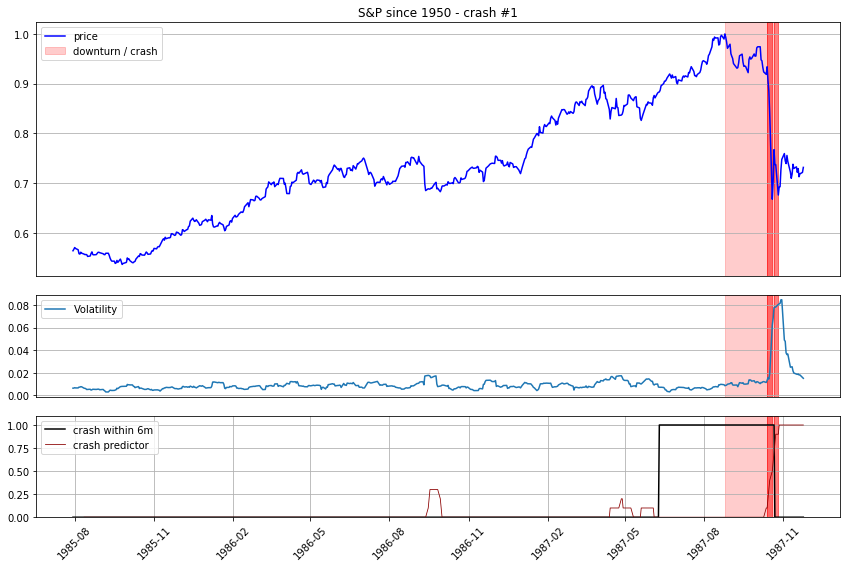

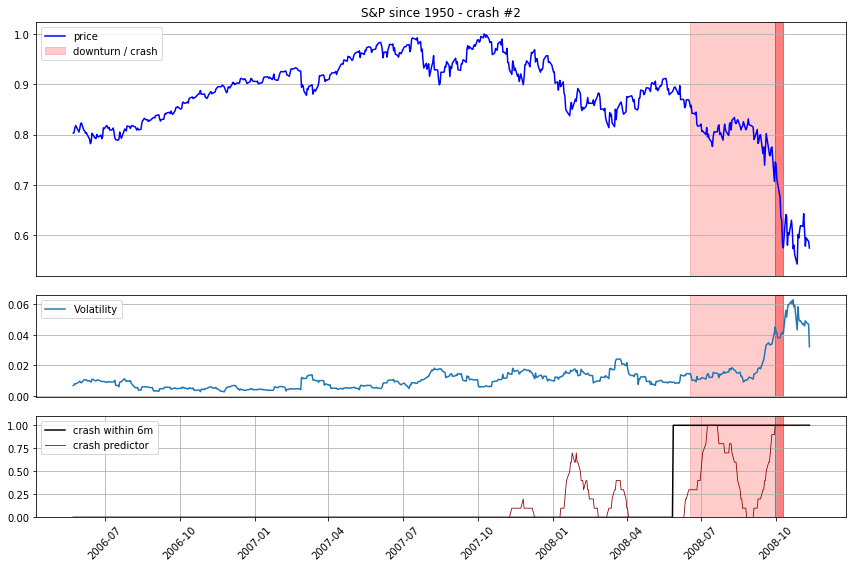

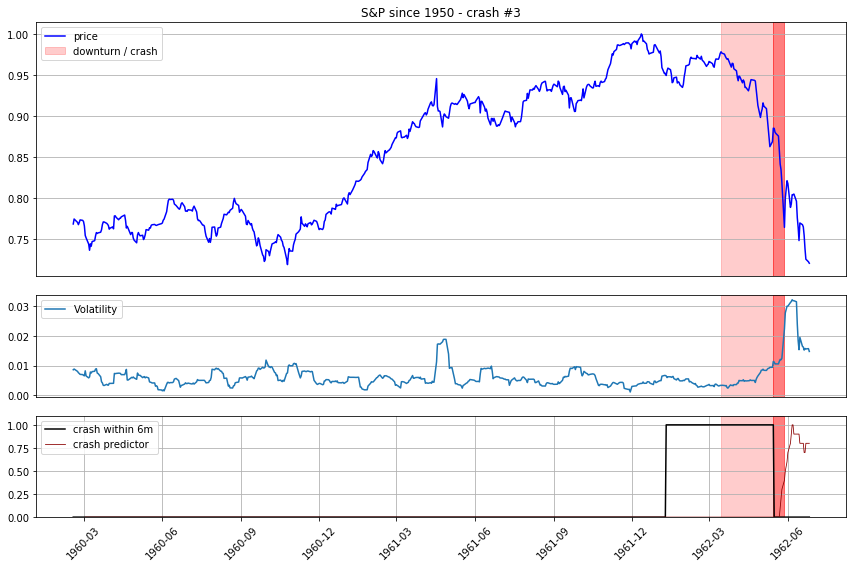

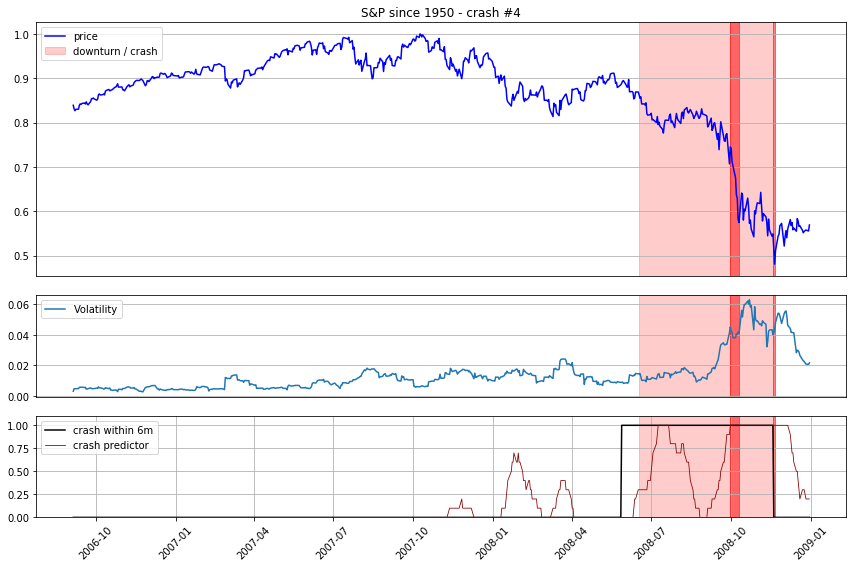

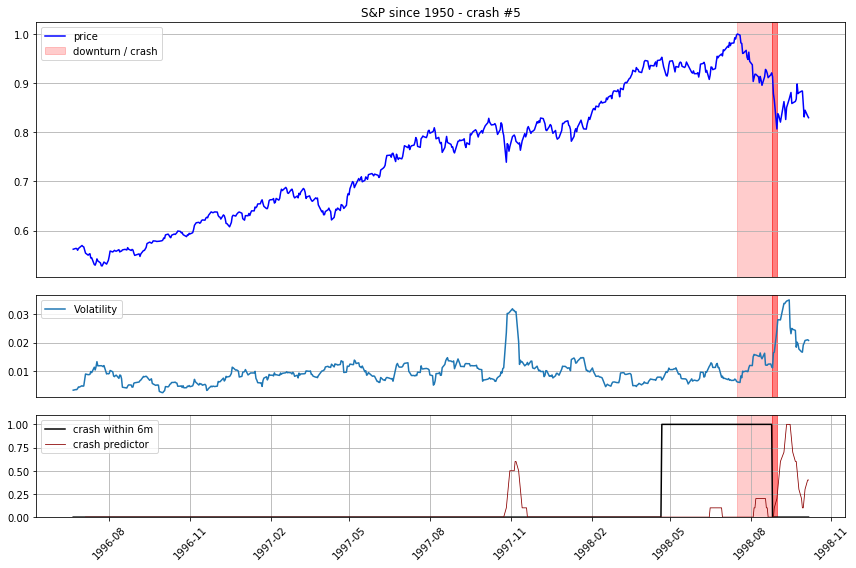

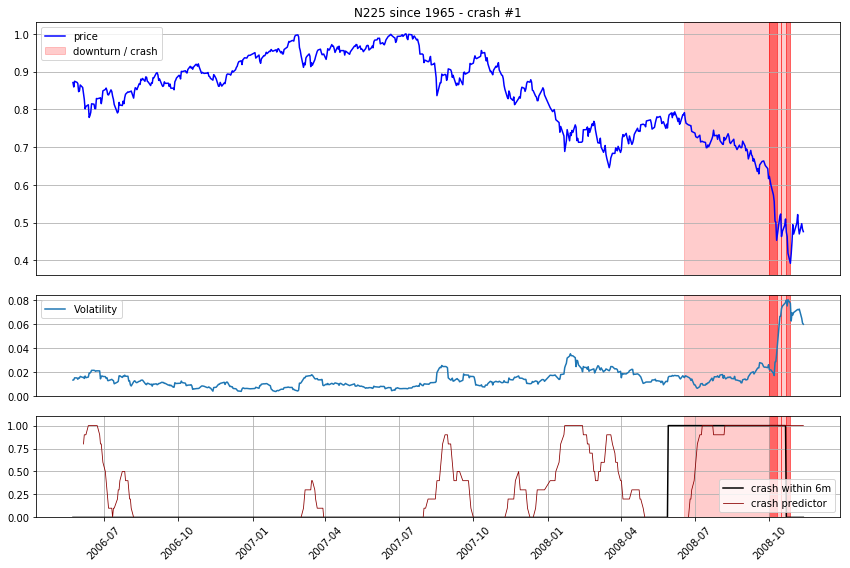

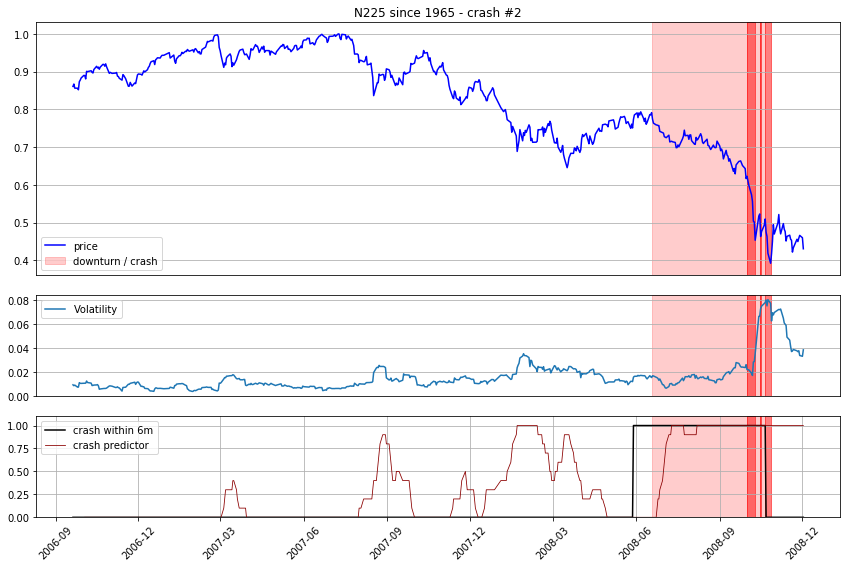

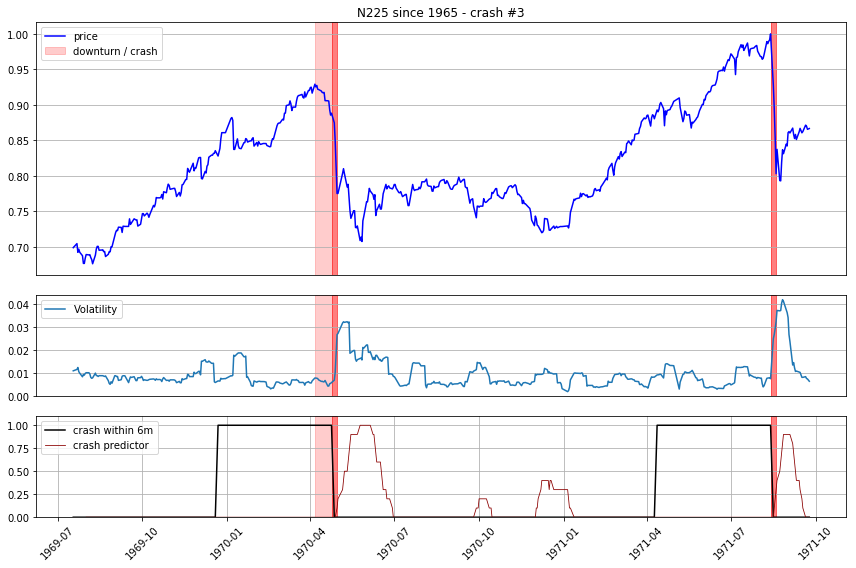

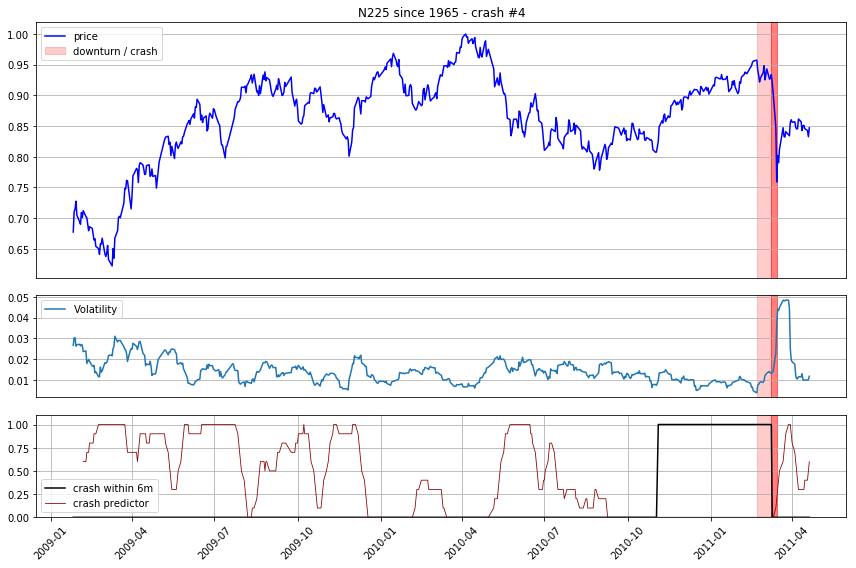

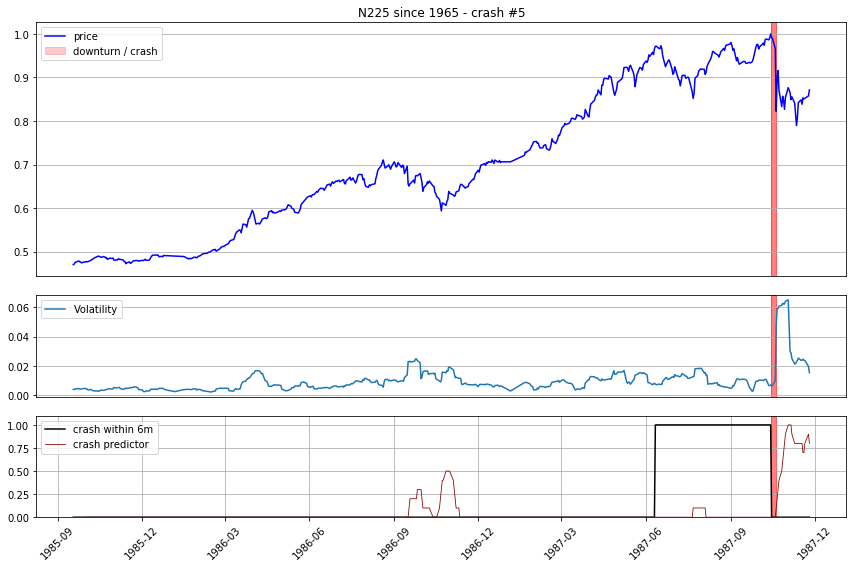

In [8]:
##### plot biggest crashes of each datasets:
n_crashes = 5
gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1]) 
for df, c, t in zip(df_results, crashes, plt_titles):
    for i in range(1, n_crashes + 1):
        t1 = c[c['rank']==i]['down_st'][0] - timedelta(3*252)
        t2 = c[c['rank']==i]['crash_st'][0] + timedelta(2*21)
        plt.subplot(gs[0])
        down_st = list(filter(lambda x: x > t1 and x < t2, c['down_st']))
        crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
        crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
        [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
        [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
        df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
        plt.plot(df_norm[t1:t2], color='blue') 
        plt.title(t + ' - crash #{}'.format(i))
        plt.legend(['price', 'downturn / crash'])
        plt.xticks([])
        plt.grid()
        plt.subplot(gs[1])
        plt.plot(df.loc[t1:t2, 'vol'])
        [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
        [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
        plt.legend(['Volatility'])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.grid()
        plt.xticks([])
        plt.subplot(gs[2])
        plt.plot(df['c_6m'][t1:t2], color='black')
        plt.plot(df['y_pred_bin_c'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
        [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
        [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
        plt.legend(['crash within 6m', 'crash predictor'])
        plt.ylim(0, 1.1)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.grid()
        plt.show()